### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math
import warnings
from os.path import join
import os

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# A. Dataset

**Data Source:** The California Weather and Fire Prediction Dataset (1984–2025) with Engineered Features is available at  https://zenodo.org/records/14712845.

### Loading Data

In [3]:
# read dataset
df = pd.read_csv('/content/drive/MyDrive/CA_Weather_Fire_Dataset_1984-2025.csv')


In [4]:
# display top 5 rows
df.head()

,DATE,PRECIPITATION,MAX_TEMP,MIN_TEMP,AVG_WIND_SPEED,FIRE_START_DAY,YEAR,TEMP_RANGE,WIND_TEMP_RATIO,MONTH,SEASON,LAGGED_PRECIPITATION,LAGGED_AVG_WIND_SPEED,DAY_OF_YEAR
0,1984-01-01,0.0,79.0,51.0,4.70,False,1984,28.0,0.059494,1,Winter,0.0,4.700,1
1,1984-01-02,0.0,71.0,46.0,5.59,False,1984,25.0,0.078732,1,Winter,0.0,5.145,2
2,1984-01-03,0.0,70.0,47.0,5.37,False,1984,23.0,0.076714,1,Winter,0.0,5.220,3
3,1984-01-04,0.0,76.0,45.0,4.70,False,1984,31.0,0.061842,1,Winter,0.0,5.090,4
4,1984-01-05,0.0,74.0,49.0,5.14,False,1984,25.0,0.069459,1,Winter,0.0,5.100,5


### Get to know the data

In [5]:
print(df['PRECIPITATION'].unique())


[0.   0.39 0.01 0.14 0.87 0.04 0.1  0.15 0.29 0.02 0.05 0.07 0.21 0.09
 0.93 0.06 0.64 0.25 0.17 0.28 0.34 1.62 0.35 0.46 0.16 0.03 0.5  0.43
 0.62 0.86 0.3  0.08 0.63 1.69 0.66 1.64 0.27 0.24 0.84 0.65 0.26 2.66
 0.52 0.78 1.22 0.13 0.7  1.89 0.12 0.18 1.44 1.12 0.82 0.4  0.22 0.51
 1.13 0.23 1.4  0.56 0.38 0.36 0.76 0.97 0.11 0.37 0.32 1.88 0.77 1.6
 0.72 0.68 0.48 0.47 1.07 0.8  0.19 0.6  0.57 1.38 0.2  1.28 1.04 0.71
 1.71 0.54 0.74 0.44 3.23 1.26 0.73 1.18 1.03 0.41 2.42 1.29 0.33 0.99
 0.75 3.5  2.93 1.16 0.81 1.67 0.69 0.61 0.53 1.25 1.9  0.31 1.45 1.37
 1.5  1.2  0.79 0.92 0.58 0.95 1.51 1.7  0.83 3.1  1.23 2.09 1.01 1.87
 0.49 1.39 0.67 0.59 1.3  0.88 0.42 1.35 1.14 1.32 2.1  0.94 2.   1.56
 1.86 2.15 1.49 1.53 1.24 0.9  4.53 1.33 1.59 1.98 1.41 1.05 0.91 0.98
 1.75 1.09 2.23 1.17 1.36 2.36 1.42 1.8  0.96 2.94 1.58 0.55 1.08 1.68
 0.85 1.06 1.73 1.63 0.89 1.48 3.12 1.02 2.04 1.77 1.97 2.03 1.15 2.49
 1.76 2.57  nan]


# B. Data Preprocessing

### Handling of Missing Values

In [6]:
# check for missing values
print(df.isnull().sum())

DATE                      0
PRECIPITATION             1
MAX_TEMP                  1
MIN_TEMP                  1
AVG_WIND_SPEED           12
FIRE_START_DAY            0
YEAR                      0
TEMP_RANGE                1
WIND_TEMP_RATIO          12
MONTH                     0
SEASON                    0
LAGGED_PRECIPITATION      0
LAGGED_AVG_WIND_SPEED     0
DAY_OF_YEAR               0
dtype: int64


In [7]:
# drop rows with missing values from X
df_clean = df.dropna()

In [8]:
# verify the shapes match
print(f"Old df shape: {df.shape}")
print(f"New df shape: {df_clean.shape}")
print(f"Number of rows dropped: {df.shape[0]-df_clean.shape[0]}")

Old df shape: (14988, 14)
New df shape: (14976, 14)
Number of rows dropped: 12


**Rationale for dropping the rows**
* Since the number of missing values is negligible compared to the size of our dataset, and we are treating each row as an independent observation, we can safely remove the rows containing missing values without affecting our analysis.



---



### Feature Engineering
**Feature to add:**
* `DAYS_WITHOUT_RAIN`

**Rationale (why add this feature?):**
* If we treat each observation as independent, using only same day precipitation means the model cannot distinguish between a dry day that follows heavy rain and a dry day that follows many consecutive dry days. Adding days without rain prevents that loss of information

In [9]:
# create copy of X
df_clean = df_clean.copy()

# True on days with any rain; False on dry days
rain_today = df_clean["PRECIPITATION"] > 0

# creates a running group number that increases by 1 every time a rainy day occurs
# this lets us split the timeline into segments separated by rain
group_id = rain_today.cumsum()


# for dry days (~rain_today), count how many consecutive dry days have occurred within each segment
# resets to 0 after each rain event (because group_id changes on rain days)
df_clean.loc[:, "DAYS_WITHOUT_RAIN"] = (~rain_today).groupby(group_id).cumcount()

df_clean.head(50)

,DATE,PRECIPITATION,MAX_TEMP,MIN_TEMP,AVG_WIND_SPEED,FIRE_START_DAY,YEAR,TEMP_RANGE,WIND_TEMP_RATIO,MONTH,SEASON,LAGGED_PRECIPITATION,LAGGED_AVG_WIND_SPEED,DAY_OF_YEAR,DAYS_WITHOUT_RAIN
0,1984-01-01,0.00,79.0,51.0,4.70,False,1984,28.0,0.059494,1,Winter,0.00,4.700000,1,0
1,1984-01-02,0.00,71.0,46.0,5.59,False,1984,25.0,0.078732,1,Winter,0.00,5.145000,2,1
2,1984-01-03,0.00,70.0,47.0,5.37,False,1984,23.0,0.076714,1,Winter,0.00,5.220000,3,2
3,1984-01-04,0.00,76.0,45.0,4.70,False,1984,31.0,0.061842,1,Winter,0.00,5.090000,4,3
4,1984-01-05,0.00,74.0,49.0,5.14,False,1984,25.0,0.069459,1,Winter,0.00,5.100000,5,4
5,1984-01-06,0.00,65.0,49.0,7.38,False,1984,16.0,0.113538,1,Winter,0.00,5.480000,6,5
6,1984-01-07,0.00,59.0,54.0,5.82,False,1984,5.0,0.098644,1,Winter,0.00,5.528571,7,6
7,1984-01-08,0.00,59.0,55.0,3.36,False,1984,4.0,0.056949,1,Winter,0.00,5.337143,8,7
8,1984-01-09,0.00,61.0,54.0,6.71,False,1984,7.0,0.110000,1,Winter,0.00,5.497143,9,8
9,1984-01-10,0.00,70.0,47.0,4.70,False,1984,23.0,0.067143,1,Winter,0.00,5.401429,10,9


### Define Explanatory and Target Variables

In [10]:
# target variable
target = "FIRE_START_DAY"

# keep all columns except target column
X = df_clean.drop(columns=[target])

# degine target column
y = df_clean[target]

# print shape of data
print(X.shape)
print(y.shape)

(14976, 14)
(14976,)


### Split Data

In [11]:
# Split data
# training - 60%
# validation - 20%
# test - 20%

X_temp, X_test, y_temp, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y_temp)


# print shape of data
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)


(8985, 14)
(8985,)
(2995, 14)
(2995,)


### Categorial Variable Encoding

In [12]:
# convert boolean to integer (False -> 0 and True -> 1)
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

# verify conversion was sucessful
print(y_train.head())
print("-" * 50)

7005    0
7038    0
4496    0
7238    1
6951    0
Name: FIRE_START_DAY, dtype: int64
--------------------------------------------------


# C. Exploratory Data analysis

### Correlation Matrix Analysis

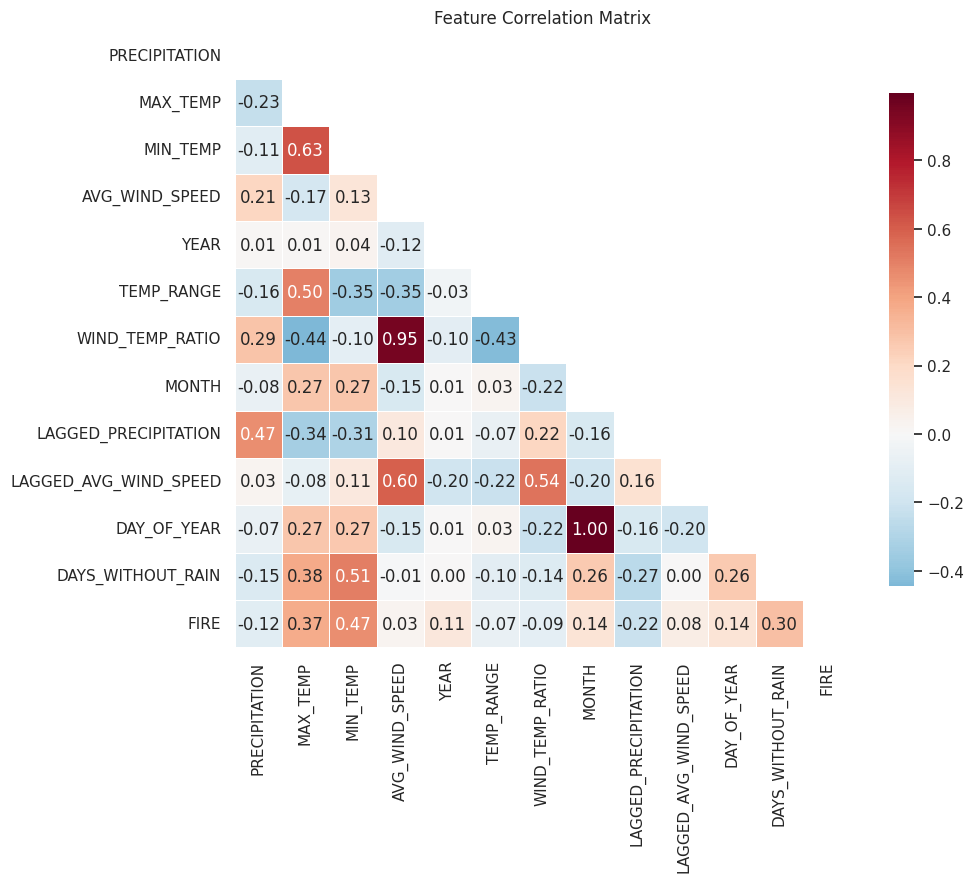

In [13]:
# correlation matrix

sns.set_theme(style="white")

corr_df = X_train.copy()
corr_df["FIRE"] = y_train

corr = corr_df.corr(numeric_only=True)

# mask
mask = np.triu(np.ones_like(corr, dtype=bool))

# plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
plt.title("Feature Correlation Matrix")
plt.show()

In [19]:
X_train.describe()

,PRECIPITATION,MAX_TEMP,MIN_TEMP,LAGGED_PRECIPITATION,DAYS_WITHOUT_RAIN
count,8985.000000,8985.000000,8985.000000,8985.00000,8985.000000
mean,0.031625,70.556928,56.492487,0.22506,29.560267
std,0.176276,7.266896,6.705380,0.64780,36.534370
min,0.000000,50.000000,35.000000,0.00000,0.000000
25%,0.000000,65.000000,52.000000,0.00000,4.000000
50%,0.000000,70.000000,57.000000,0.00000,14.000000
75%,0.000000,75.000000,62.000000,0.06000,41.000000
max,4.530000,106.000000,77.000000,8.18000,221.000000


### Feature Selection

**Features to keep:**
1. `PRECIPITATION`
2. `MAX_TEMP`
3. `MIN_TEMP`
4. `LAGGED_PRECIPITATION`
5. `DAYS_WITHOUT_RAIN`

**Features to drop:**
1. `DATE`
2. `YEAR`
3. `TEMP_RANGE`
4. `WIND_TEMP_RATIO`
5. `MONTH`
6. `SEASON`
7. `LAGGED_AVG_WIND_SPEED`
8. `DAY_OF_YEAR`
9. `AVG_WIND_SPEED`

**Rationale (why drop them?):**
* **Temporal Features** (Date, Year, Month, Season, Day of Year): Fires are caused by specific weather conditions (heat, dryness, wind), not by the date itself.
* **Temperature Range**: This creates multicollinearity because it is perfectly calculated from Max Temperature and Min Temperature, which are already included.
* **Wind-Temp Ratio**: This is a derived feature that is likely highly correlated with the existing wind and temperature variables, adding noise without adding new information.
* **Lagged Avg Wind Speed**: Unlike precipitation (which accumulates as soil moisture), yesterday's wind speed has no physical impact on today’s ignition probability.
* **Avg Wind Speed:** same rationale as for lagged avg wind speed

In [14]:
# keep only relevant columns
X_train = X_train.copy()

# drop columns

cols = [
    "PRECIPITATION",
    "MAX_TEMP",
    "MIN_TEMP",
    "LAGGED_PRECIPITATION",
    "DAYS_WITHOUT_RAIN"
]

# dataset with relevant columns only
X_train = X_train[cols]

# print
print(X_train.shape)


(8985, 5)


### Correlation Matrix Analysis After Selection


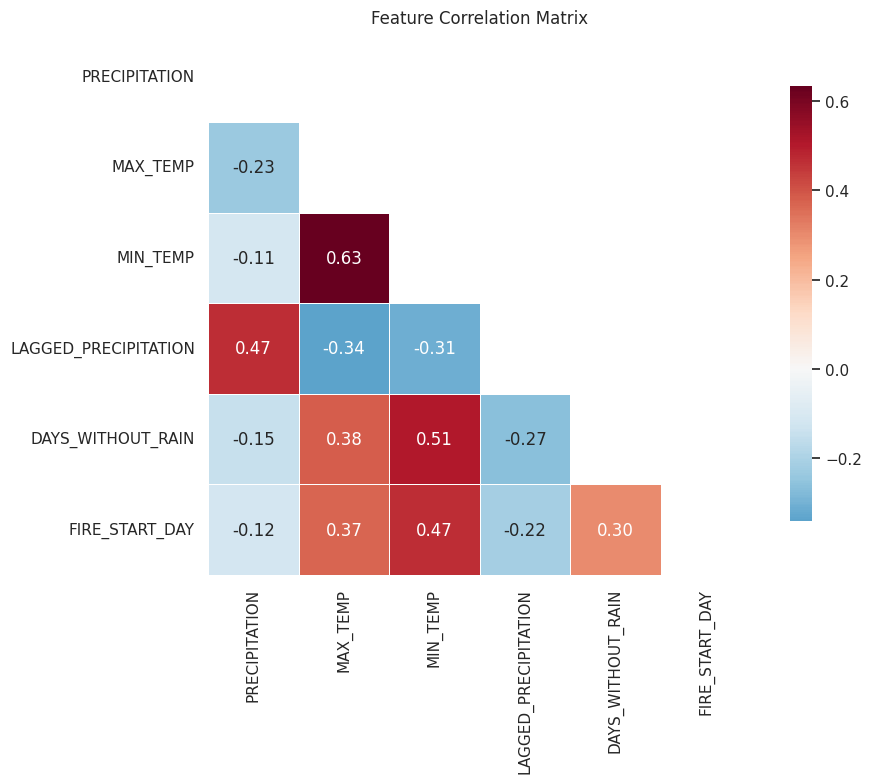

In [15]:
# correlation matrix

sns.set_theme(style="white")

X_corr_df = X_train.copy()
X_corr_df["FIRE_START_DAY"] = y_train

X_corr = X_corr_df.corr(numeric_only=True)

# mask
mask = np.triu(np.ones_like(X_corr, dtype=bool))

# plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    X_corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

### Feature Scaling

In [16]:
scaler = StandardScaler()

X_val  = X_val[X_train.columns]
X_test = X_test[X_train.columns]


X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# D. Data Visualizations

### Bar Plot

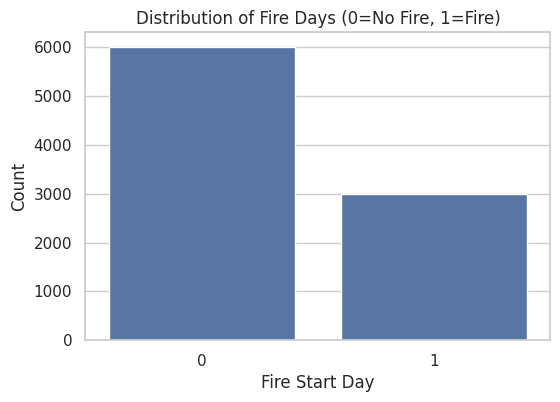

--------------------------------------------------
FIRE_START_DAY
0    6002
1    2983
Name: count, dtype: int64
Percentage of Fire Days: 33.20%


In [17]:
# Set style
sns.set(style="whitegrid")

# visualize target variable (Fire vs No Fire)
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title("Distribution of Fire Days (0=No Fire, 1=Fire)")
plt.xlabel("Fire Start Day")
plt.ylabel("Count")
plt.show()

# print exact numbers
print("-" * 50)
print(y_train.value_counts())
print("Percentage of Fire Days: {:.2f}%".format(y_train.mean() * 100))

### Pair Plots

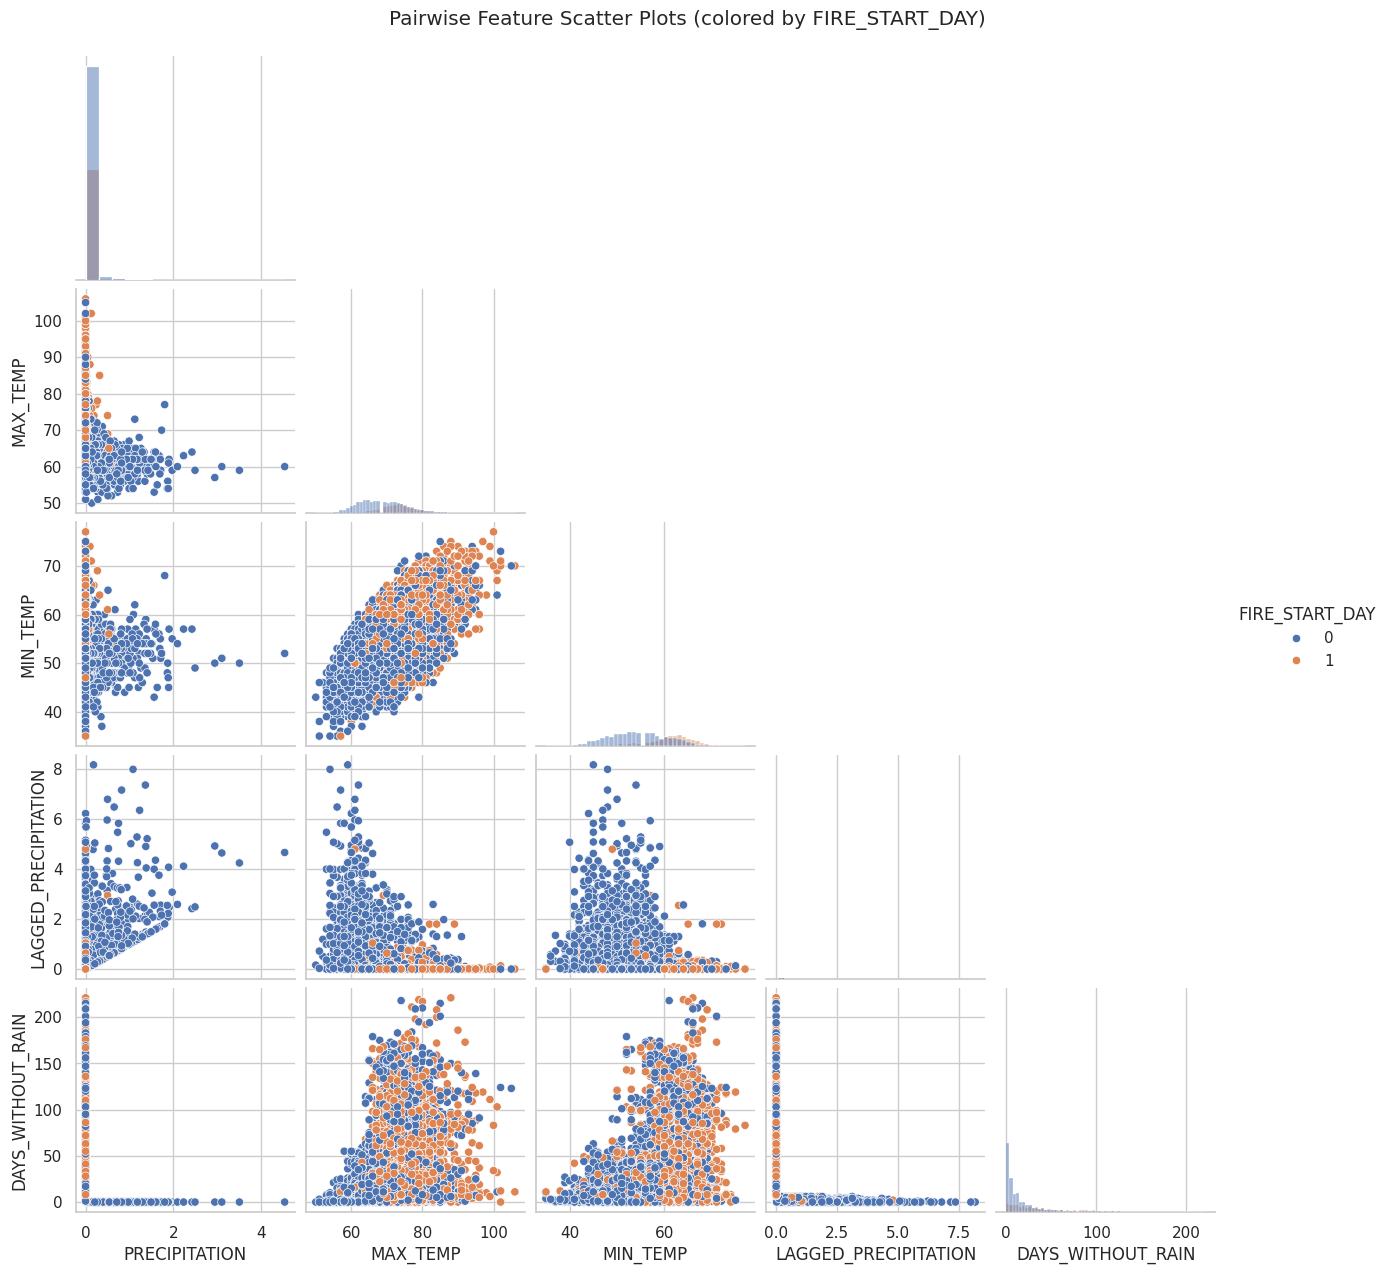

In [18]:
plot_df = X_train.copy()

plot_df["FIRE_START_DAY"] = y_train

sns.pairplot(
    plot_df,
    hue="FIRE_START_DAY",
    corner=True,          # only lower triangle (less redundant)
    diag_kind="hist",     # histogram on the diagonal
)

plt.suptitle("Pairwise Feature Scatter Plots (colored by FIRE_START_DAY)", y=1.02)
plt.show()